In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import binary_opening, disk, label
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import keras
import keras.backend as K
import pandas as pd
import tensorflow as tf
from keras import layers, models
from keras.callbacks import (Callback, EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, ReduceLROnPlateau)
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.test_utils import get_test_data, keras_test
from tqdm import tqdm

import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)


print(os.listdir("input"))


Using TensorFlow backend.


['test_ship_segmentations.csv', 'sample_submission.csv', 'train_ship_segmentations.csv', 'test', 'train']


In [3]:
INPUT_DIR = "input"
CHECKPOINTS_DIR = 'checkpoints'
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR,"test")
WEIGHT_PATH = os.path.join(CHECKPOINTS_DIR, "simple_unet_weights.best.hdf5")
MODEL_NAME = 'simple_unet'
FULL_RES_MODEL_NAME = 'simple_unet_full_res'

AUGMENT_BRIGHTNESS = False
GAUSSIAN_NOISE = 0.1

DEFAULT_THRESHOLDS = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
VALID_IMG_COUNT = 1000
IMG_SCALING = (2,2)
NET_SCALING = (1,1)
BATCH_SIZE = 50
UPSAMPLE_MODE = 'SIMPLE'
MAX_TRAIN_STEPS = 20
MAX_TRAIN_EPOCHS = 99


In [4]:
df = pd.read_csv(os.path.join(INPUT_DIR, "train_ship_segmentations.csv"))
df.head()


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


# 1. Training dataset stats

In [5]:
# 1. Use only image with ships
# 2. Pretrained U-net CNN model, ResNet, Ternaus on ImageNet
# 3. Try to learn on 768x768 images


# TODO:
# 1. Check results
# 2. Crete repo for models and learning them by scripts with notbooks only to visualization and predicting

In [6]:
num_of_all_images = len(df.drop_duplicates('ImageId'))
num_of_no_ships_images = sum(pd.isnull(df['EncodedPixels']))
num_of_all_rows = len(df)

print("Number of images: {}".format(num_of_all_images))
print("Number of images without ships: {}".format(num_of_no_ships_images))
print("Number of images with ships: {}".format(num_of_all_images - num_of_no_ships_images))
print("Number of ships: {}".format(num_of_all_rows - num_of_no_ships_images))

# We can consider that dataset is not balanced enough

Number of images: 104070
Number of images without ships: 75000
Number of images with ships: 29070
Number of ships: 56030


# 2. RLE encoding and decoding

In [7]:
def rle_decode(rle_mask, shape=(768,768)):
    '''
    rle_mask: run-length encoded string
    img: image coresponding to rle_mask
    Returns numpy array, 1 - mask, 0 - background
    '''
    rle_mask_list = rle_mask.split(" ")
    starts, lengths = [np.array(pair, dtype=int) for pair in (rle_mask_list[::2], rle_mask_list[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run-length encoded string
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

## Check if above functions work properly

In [8]:
df.loc[df['ImageId'] =="00021ddc3.jpg"]

,ImageId,EncodedPixels
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
5,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...
6,00021ddc3.jpg,139644 2 140408 6 141174 9 141942 9 142711 6 1...
7,00021ddc3.jpg,86727 2 87493 4 88261 4 89030 3 89798 4 90566 ...
8,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
9,00021ddc3.jpg,75972 3 76738 5 77506 5 78274 5 79042 6 79811 ...
10,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [9]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (30, 10))
# rle_0 = df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
# img_0 = masks_as_image(rle_0)
# ax1.imshow(img_0)
# ax1.set_title('Mask as image')
# rle_1 = multi_rle_encode(img_0)
# img_1 = masks_as_image(rle_1)
# ax2.imshow(img_1)
# ax2.set_title('Re-encoded')
# img_2 = masks_as_color(rle_0)
# ax3.imshow(img_2)
# ax3.set_title('Masks in colors')
# img_3 = masks_as_color(rle_1)
# ax4.imshow(img_3)
# ax4.set_title('Re-encoded in colors')

# img_4 = cv2.imread(os.path.join(TRAIN_DIR, '00021ddc3.jpg'))
# ax5.imshow(img_4)
# ax5.set_title('Real image')


# print('Check Decoding->Encoding',
#       'RLE_0:', len(rle_0), '->',
#       'RLE_1:', len(rle_1))
# print(np.sum(img_0 - img_1), 'error')

# 3. Split to taining and validation datasets

,ImageId,ships,has_ship,file_size_kb
76192,bb4c9f2f2.jpg,0,0.0,115.166992
41678,66965bf58.jpg,0,0.0,200.981445
56345,8a7909f33.jpg,0,0.0,204.885742
69917,abf2b7e41.jpg,1,1.0,123.200195
77289,be0f07aa6.jpg,2,1.0,125.810547
65966,a22d5d37d.jpg,1,1.0,213.482422
60021,93875a5a5.jpg,0,0.0,161.100586


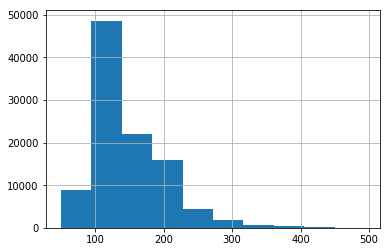

In [10]:
df['ships'] = df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(TRAIN_DIR, c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
df.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)


## Ships number histogram

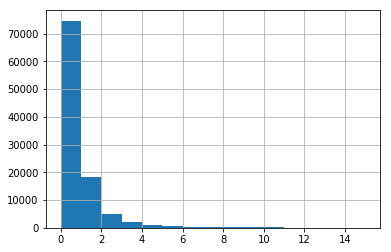

In [11]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

## Drop empty images

28693 masks


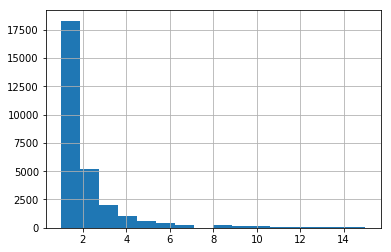

In [12]:
# SAMPLES_PER_GROUP = 10000
# balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df = unique_img_ids[unique_img_ids.ships != 0]

balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')



In [13]:
train_ids, valid_ids = train_test_split(balanced_train_df, test_size=VALID_IMG_COUNT, stratify = balanced_train_df['ships'])
train_df = pd.merge(df, train_ids)
valid_df = pd.merge(df, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
train_df.head()


53459 training masks
1930 validation masks


,ImageId,EncodedPixels,ships,has_ship,file_size_kb
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,1.0,147.625977
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9,1.0,242.910156
2,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9,1.0,242.910156
3,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9,1.0,242.910156
4,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...,9,1.0,242.910156


In [14]:
def make_image_gen(in_df, batch_size=BATCH_SIZE, img_scaling=IMG_SCALING):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(TRAIN_DIR, c_img_id)
            c_img = cv2.imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::img_scaling[0], ::img_scaling[1]]
                c_mask = c_mask[::img_scaling[0], ::img_scaling[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

## Create validation dataset

In [15]:
valid_gen = make_image_gen(valid_df, VALID_IMG_COUNT)
valid_x, valid_y = next(valid_gen)
print('x', valid_x.shape, valid_x.min(), valid_x.max())
print('y', valid_y.shape, valid_y.min(), valid_y.max())

x (1000, 384, 384, 3) 0.0 1.0
y (1000, 384, 384, 1) 0 1


Text(0.5,1,'Outlined Ships')

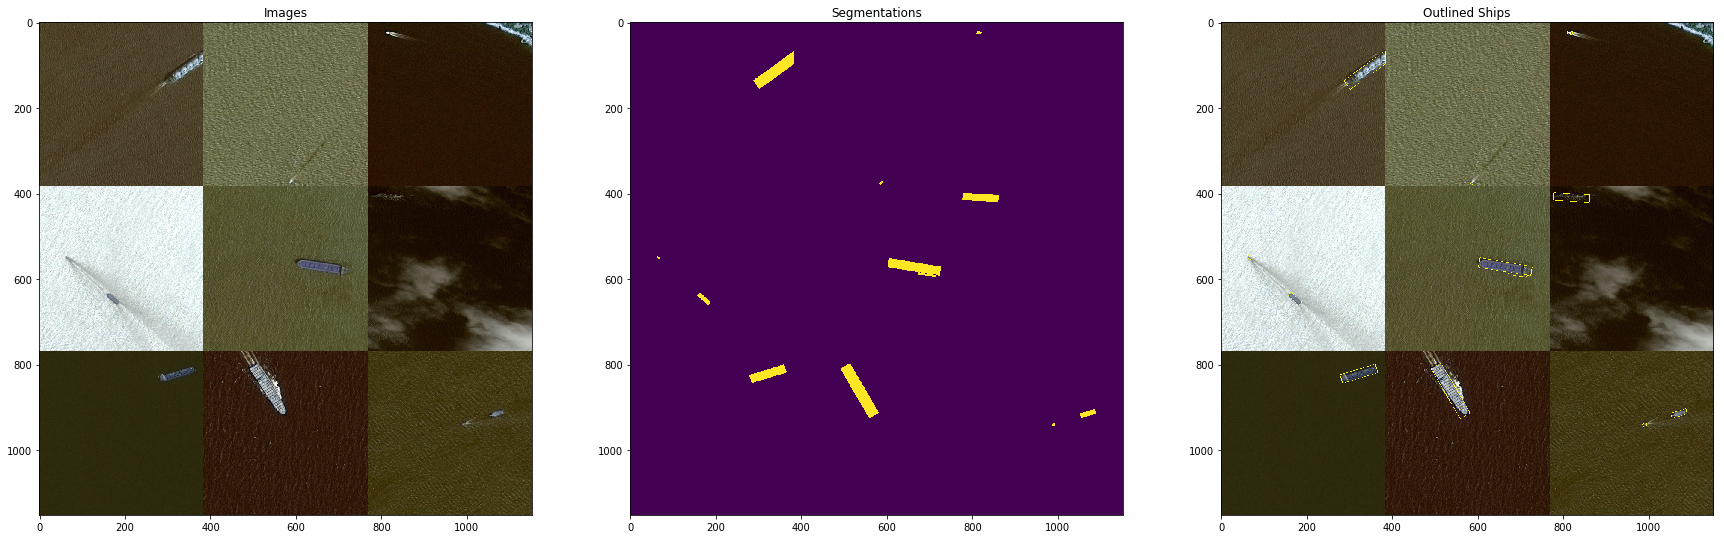

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(valid_x[:9])
batch_seg = montage(valid_y[:9, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax3.set_title('Outlined Ships')


## Data augmentation

In [17]:
dg_args = dict(rotation_range = 45, 
               width_shift_range = 0.1, 
               height_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.25],  
               horizontal_flip = True, 
               vertical_flip = True,
               fill_mode = 'reflect',
               data_format = 'channels_last')

# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args['brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [18]:
gc.collect()

5795

# 4. Model

In [19]:
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(valid_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 384, 384, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 384, 384, 3)  0           average_pooling2d_1[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 384, 384, 3)  12          gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (

In [20]:
def kaggle_IoU(y_true, y_pred):
    gc.collect()
    score_list = []
    for thresh in DEFAULT_THRESHOLDS:
        iou = IoU(y_true, y_pred, thresh=thresh)
        score_list.append(iou)

    return K.mean(tf.convert_to_tensor(score_list))

def IoU(y_true, y_pred, thresh=0.5, eps=1e-6):
    y_pred = tf.to_float(tf.to_int32(y_pred > thresh))
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + eps) / (union + eps)

def dice_loss(y_true, y_pred, smooth=1.):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return 1 - (2.0 * intersection + smooth) / (union + smooth)

def bin_cross_and_IoU(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - 10 * K.log(1 - dice_loss(y_true, y_pred))

In [21]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [22]:
checkpoint = ModelCheckpoint(WEIGHT_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.00001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=10)

callbacks_list = [checkpoint, early, reduceLROnPlat]



In [ ]:
def fit():
    try:
        seg_model.load_weights(WEIGHT_PATH)
    except OSError:
        print('No file with weights available! Starting from scratch...')
    seg_model.compile(optimizer=Adam(0.001, decay=0.000001), loss=bin_cross_and_IoU, metrics=['binary_accuracy', IoU, kaggle_IoU])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [seg_model.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                 workers=1)]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < 4.0:
        break


Epoch 1/99
20/20 [==============================] - 100s 5s/step - loss: 5.2724 - binary_accuracy: 0.9952 - IoU: 0.4296 - kaggle_IoU: 0.4297 - val_loss: 4.8257 - val_binary_accuracy: 0.9961 - val_IoU: 0.4566 - val_kaggle_IoU: 0.4562

Epoch 00001: val_loss improved from inf to 4.82573, saving model to checkpoints/simple_unet_weights.best.hdf5
Epoch 2/99
20/20 [==============================] - 83s 4s/step - loss: 6.5644 - binary_accuracy: 0.9938 - IoU: 0.3630 - kaggle_IoU: 0.3626 - val_loss: 5.2270 - val_binary_accuracy: 0.9962 - val_IoU: 0.4313 - val_kaggle_IoU: 0.4290

Epoch 00002: val_loss did not improve from 4.82573

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 3/99
20/20 [==============================] - 82s 4s/step - loss: 5.1566 - binary_accuracy: 0.9959 - IoU: 0.4371 - kaggle_IoU: 0.4361 - val_loss: 4.9336 - val_binary_accuracy: 0.9957 - val_IoU: 0.4496 - val_kaggle_IoU: 0.4513

Epoch 00003: val_loss did not improve from 4.82573

Epoch


Epoch 00025: val_loss did not improve from 4.80694
Epoch 26/99
20/20 [==============================] - 84s 4s/step - loss: 5.6657 - binary_accuracy: 0.9951 - IoU: 0.4078 - kaggle_IoU: 0.4071 - val_loss: 4.8232 - val_binary_accuracy: 0.9959 - val_IoU: 0.4565 - val_kaggle_IoU: 0.4575

Epoch 00026: val_loss did not improve from 4.80694
Epoch 00026: early stopping
Epoch 1/99
20/20 [==============================] - 96s 5s/step - loss: 6.1330 - binary_accuracy: 0.9947 - IoU: 0.3864 - kaggle_IoU: 0.3861 - val_loss: 7.9676 - val_binary_accuracy: 0.9903 - val_IoU: 0.3042 - val_kaggle_IoU: 0.3092

Epoch 00001: val_loss did not improve from 4.80694
Epoch 2/99
20/20 [==============================] - 80s 4s/step - loss: 6.5975 - binary_accuracy: 0.9939 - IoU: 0.3609 - kaggle_IoU: 0.3612 - val_loss: 6.0427 - val_binary_accuracy: 0.9937 - val_IoU: 0.3883 - val_kaggle_IoU: 0.3945

Epoch 00002: val_loss did not improve from 4.80694
Epoch 3/99
20/20 [==============================] - 81s 4s/step - l

20/20 [==============================] - 82s 4s/step - loss: 5.4354 - binary_accuracy: 0.9953 - IoU: 0.4167 - kaggle_IoU: 0.4154 - val_loss: 4.8083 - val_binary_accuracy: 0.9961 - val_IoU: 0.4587 - val_kaggle_IoU: 0.4594

Epoch 00007: val_loss did not improve from 4.75115

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 8/99
20/20 [==============================] - 84s 4s/step - loss: 5.3852 - binary_accuracy: 0.9957 - IoU: 0.4235 - kaggle_IoU: 0.4231 - val_loss: 4.8012 - val_binary_accuracy: 0.9961 - val_IoU: 0.4591 - val_kaggle_IoU: 0.4599

Epoch 00008: val_loss did not improve from 4.75115

Epoch 00008: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
Epoch 9/99
20/20 [==============================] - 84s 4s/step - loss: 5.5876 - binary_accuracy: 0.9955 - IoU: 0.4085 - kaggle_IoU: 0.4076 - val_loss: 4.7848 - val_binary_accuracy: 0.9961 - val_IoU: 0.4603 - val_kaggle_IoU: 0.4609

Epoch 00009: val_loss did not improve from 4.751

20/20 [==============================] - 84s 4s/step - loss: 4.7516 - binary_accuracy: 0.9961 - IoU: 0.4604 - kaggle_IoU: 0.4598 - val_loss: 4.5595 - val_binary_accuracy: 0.9961 - val_IoU: 0.4747 - val_kaggle_IoU: 0.4765

Epoch 00008: val_loss did not improve from 4.50156

Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 9/99
20/20 [==============================] - 84s 4s/step - loss: 4.7756 - binary_accuracy: 0.9957 - IoU: 0.4604 - kaggle_IoU: 0.4602 - val_loss: 4.5304 - val_binary_accuracy: 0.9961 - val_IoU: 0.4765 - val_kaggle_IoU: 0.4781

Epoch 00009: val_loss did not improve from 4.50156

Epoch 00009: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 10/99
20/20 [==============================] - 85s 4s/step - loss: 5.1871 - binary_accuracy: 0.9954 - IoU: 0.4338 - kaggle_IoU: 0.4333 - val_loss: 4.5248 - val_binary_accuracy: 0.9962 - val_IoU: 0.4768 - val_kaggle_IoU: 0.4784

Epoch 00010: val_loss did not improve from 4.5


Epoch 00015: val_loss did not improve from 4.50156
Epoch 00015: early stopping
Epoch 1/99
20/20 [==============================] - 96s 5s/step - loss: 5.0953 - binary_accuracy: 0.9955 - IoU: 0.4417 - kaggle_IoU: 0.4410 - val_loss: 4.8615 - val_binary_accuracy: 0.9956 - val_IoU: 0.4549 - val_kaggle_IoU: 0.4574

Epoch 00001: val_loss did not improve from 4.50156
Epoch 2/99
13/20 [==================>...........] - ETA: 23s - loss: 5.4441 - binary_accuracy: 0.9954 - IoU: 0.4164 - kaggle_IoU: 0.4162

In [ ]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [ ]:
seg_model.load_weights(WEIGHT_PATH)
seg_model.save(os.path.join(CHECKPOINTS_DIR, '{}.h5'.format(MODEL_NAME)))

In [ ]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

In [ ]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save(os.path.join(CHECKPOINTS_DIR, '{}.h5'.format(FULL_RES_MODEL_NAME)))


In [ ]:
def predict(img, path=TEST_DIR, thresh=0.5):
    c_img = cv2.imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg[cur_seg > thresh] = 1
    cur_seg[cur_seg < thresh] = 0
    return cur_seg, c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = predict(c_img_name, TRAIN_DIR)
    ax1.imshow(first_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0])
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(first_seg[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Re-encoded')
    ground_truth = masks_as_color(df.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
  
    
    
# fig.savefig('validation.png')

# 5. SUBMISSION

In [ ]:
test_paths = np.array(os.listdir(TEST_DIR))
print(len(test_paths), 'test images found')


In [ ]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:30000]): ## only a subset as it takes too long to run
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

In [ ]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

In [ ]:
## let's see what we got
TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = imread(os.path.join(test_image_dir, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')

In [ ]:
sub1 = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission.csv', index=False)
sub.head()

